In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

228813984/228813984 [==============================] - 6s 0us/step


In [4]:
print(data_dir)

/root/.keras/datasets/flower_photos


In [5]:
data_dir = pathlib.Path(data_dir)  # 탐색가능 directory 객체

In [6]:
# 특정 속성의 파일 탐색
image_count = len(list(data_dir.glob('*/*.jpg')))  # flower_photos 하위 폴더 상관없이 jpg파일 탐색
print(image_count)

3670


In [7]:
daisy = list(data_dir.glob('daisy/*'))           # 데이지 폴더 내무의 모든 파일을 daisy에 저장
dandelion = list(data_dir.glob('dandelion/*'))   # 단델리온 폴더 내무의 모든 파일을 dandelion에 저장
roses = list(data_dir.glob('roses/*'))           # 장미 폴더 내무의 모든 파일을 roses에 저장
sunflowers = list(data_dir.glob('sunflowers/*')) # 해바라기 폴더 내무의 모든 파일을 sunflowers에 저장
tulips = list(data_dir.glob('tulips/*'))         # 튤립 폴더 내무의 모든 파일을 tulips에 저장

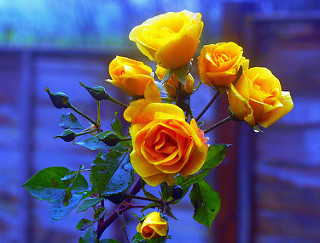

In [8]:
PIL.Image.open(roses[10])               # 출력

In [9]:
tulips = list(data_dir.glob('tulips/*'))  # 튤립 폴더 내무의 모든 파일을 tulips에 저장

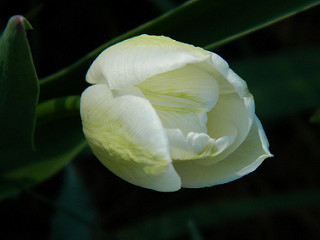

In [10]:
PIL.Image.open(tulips[0])                 # 출력

In [11]:
batch_size = 32
image_height = 180
image_width = 180

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(       # ImageDataGenerator 기능과 비슷.
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names       # 폴더 탐색해서 폴더명 추출
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


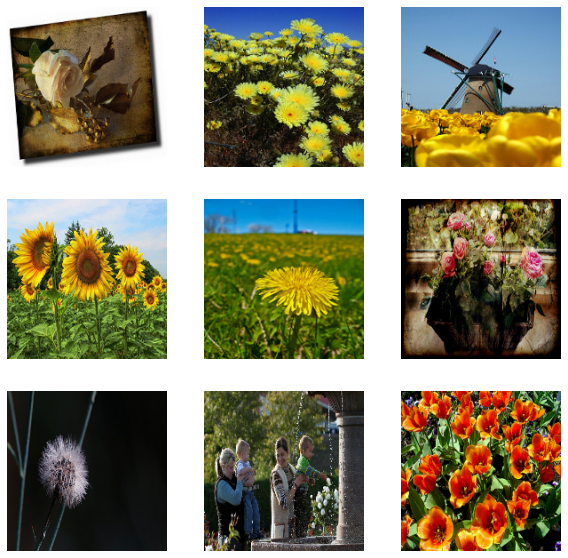

In [14]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1) :
  #print(len(images))
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))        # 정수형 변환해야 정상 출력
    plt.axis('off')

plt.show()

In [15]:
# 병렬처리 (속도향상 위해)
AUTOTUNE = tf.data.experimental.AUTOTUNE      # 버퍼공간 확보
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)  

In [16]:
버퍼 공간을 활용하여 섞음
이렇게 섞을때 데잍의 처리가 동시에 일어날 수 있도록.,.
데이터가 일단 들어오고 이미지를 읽는데 
읽을 공간을 버퍼공간이 충분하면 미리 다 읽는다
버퍼공간으로 미리 읽고 신경망에 바로바로 넣을 수 있다.. 시간이 적게 들 수 있음..

SyntaxError: ignored

In [20]:
num_classes = 5
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1/255,
                                                input_shape = (image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    # 병렬처리 속성설정(from_logits=True)위해
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [21]:
history = model.fit(train_ds, validation_data = val_ds, epochs=15)   # 과적합..!!

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


92/92 [==============================] - 18s 39ms/step - loss: 1.3190 - accuracy: 0.4336 - val_loss: 1.1290 - val_accuracy: 0.5259
Epoch 2/15
92/92 [==============================] - 2s 24ms/step - loss: 0.9935 - accuracy: 0.6121 - val_loss: 1.1063 - val_accuracy: 0.5599
Epoch 3/15
92/92 [==============================] - 2s 24ms/step - loss: 0.8048 - accuracy: 0.6911 - val_loss: 0.9018 - val_accuracy: 0.6485
Epoch 4/15
92/92 [==============================] - 2s 23ms/step - loss: 0.5962 - accuracy: 0.7715 - val_loss: 0.8896 - val_accuracy: 0.6540
Epoch 5/15
92/92 [==============================] - 2s 23ms/step - loss: 0.4063 - accuracy: 0.8593 - val_loss: 0.9691 - val_accuracy: 0.6362
Epoch 6/15
92/92 [==============================] - 2s 23ms/step - loss: 0.2400 - accuracy: 0.9179 - val_loss: 1.1047 - val_accuracy: 0.6362
Epoch 7/15
92/92 [==============================] - 2s 23ms/step - loss: 0.1381 - accuracy: 0.9598 - val_loss: 1.3284 - val_accuracy: 0.6621
Epoch 8/15
92/92 [=====

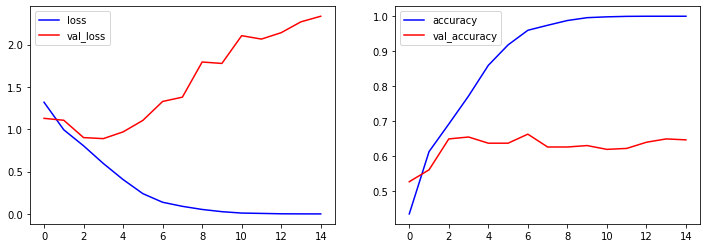

In [22]:
# 훈련결과 시각화
plt.figure(figsize=(12,4))

plt.subplot(1,2,1) # loss (loss, val_loss)
plt.plot(history.history['loss'], 'b-', label='loss')                  # 훈련 손실
plt.plot(history.history['val_loss'], 'r-', label='val_loss')          # 검증 손실
plt.legend()

plt.subplot(1,2,2) # accuracy (accuracy, val_accuracy)
plt.plot(history.history['accuracy'], 'b-', label='accuracy')          # 훈련 정확도
plt.plot(history.history['val_accuracy'], 'r-', label='val_accuracy')  # 검증 정확도
plt.legend()
plt.show()

In [23]:
# 과적합 해결 >> 이미지 증강 or drop
# 이미지 증강
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',
                                                 input_shape = (image_height, image_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

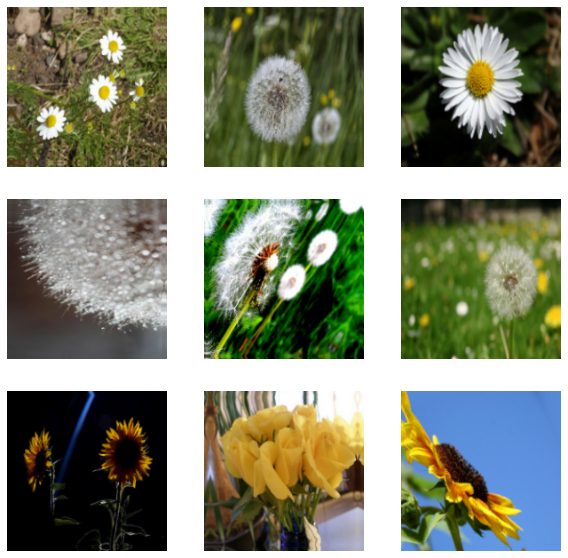

In [24]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1) :
  #print(len(images))
  for i in range(9):
    augmented_images = data_augmentation(images)
    plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[i].numpy().astype('uint8'))        # 정수형 변환해야 정상 출력
    plt.axis('off')

plt.show()

In [25]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255., ),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [26]:
history = model.fit(train_ds, validation_data = val_ds, epochs=15)

Epoch 1/15
92/92 [==============================] - 6s 55ms/step - loss: 1.4135 - accuracy: 0.3597 - val_loss: 1.1254 - val_accuracy: 0.5218
Epoch 2/15
92/92 [==============================] - 5s 55ms/step - loss: 1.0658 - accuracy: 0.5766 - val_loss: 1.0236 - val_accuracy: 0.5954
Epoch 3/15
92/92 [==============================] - 4s 40ms/step - loss: 0.9632 - accuracy: 0.6257 - val_loss: 1.0312 - val_accuracy: 0.5858
Epoch 4/15
92/92 [==============================] - 4s 40ms/step - loss: 0.8829 - accuracy: 0.6706 - val_loss: 0.9091 - val_accuracy: 0.6349
Epoch 5/15
92/92 [==============================] - 4s 39ms/step - loss: 0.8370 - accuracy: 0.6812 - val_loss: 0.8863 - val_accuracy: 0.6308
Epoch 6/15
92/92 [==============================] - 4s 39ms/step - loss: 0.7757 - accuracy: 0.7027 - val_loss: 0.8102 - val_accuracy: 0.6839
Epoch 7/15
92/92 [==============================] - 4s 39ms/step - loss: 0.7289 - accuracy: 0.7214 - val_loss: 0.7883 - val_accuracy: 0.6948
Epoch 8/15
92

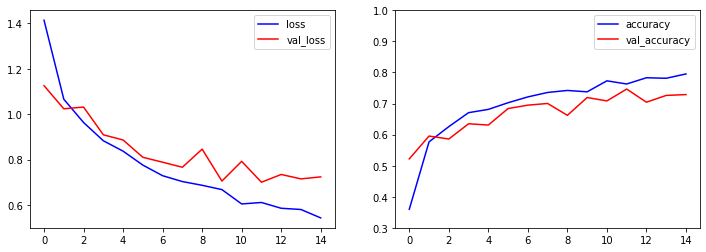

In [27]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r-', label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='val_accuracy')
plt.legend()
plt.ylim(0.3, 1.0)

plt.show()

In [29]:
# SimpleRNN 구현

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout, Dense 
from sklearn.preprocessing import MinMaxScaler

In [31]:
df = pd.read_csv('/content/drive/MyDrive/equip11.csv')
df.head()

,regdate,temp1,temp2,temp3,temp4,temp5,temp6
0,2019-04-10 8:00,19.5,-81.4,-9.7,32.4,50.4,34.4
1,2019-04-10 8:01,20.8,-81.0,-5.1,32.3,51.6,34.2
2,2019-04-10 8:02,21.5,-80.6,-1.6,32.2,52.6,33.9
3,2019-04-10 8:08,33.0,-78.9,-20.8,33.7,51.5,36.9
4,2019-04-10 8:09,33.8,-78.6,-25.1,33.6,48.9,35.2


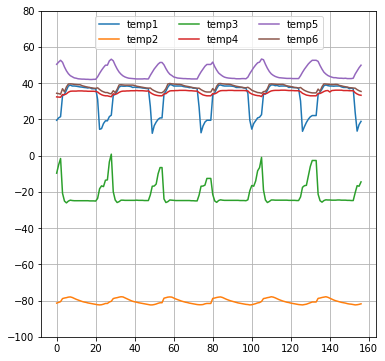

In [48]:
plt.figure(figsize=(6,6))

plt.plot(df['temp1'], label='temp1')
plt.plot(df['temp2'], label='temp2')
plt.plot(df['temp3'], label='temp3')
plt.plot(df['temp4'], label='temp4')
plt.plot(df['temp5'], label='temp5')
plt.plot(df['temp6'], label='temp6')
plt.grid()
plt.legend(loc=9, ncol=3)
plt.ylim([-100,80])
plt.show()

그래프와 같은 패턴의 움직임이면 이상 없음..  
다른 패턴이 나온다면 이상 감지 !

In [49]:
# 문자열을 날짜 형식으로 변환
df['regdate'] = pd.to_datetime(df.regdate, format='%Y-%m-%d %H:%M')
df.head()

,regdate,temp1,temp2,temp3,temp4,temp5,temp6
0,2019-04-10 08:00:00,19.5,-81.4,-9.7,32.4,50.4,34.4
1,2019-04-10 08:01:00,20.8,-81.0,-5.1,32.3,51.6,34.2
2,2019-04-10 08:02:00,21.5,-80.6,-1.6,32.2,52.6,33.9
3,2019-04-10 08:08:00,33.0,-78.9,-20.8,33.7,51.5,36.9
4,2019-04-10 08:09:00,33.8,-78.6,-25.1,33.6,48.9,35.2


In [50]:
df.index = df['regdate']  # 날짜를 인덱스로 설정

In [51]:
data = df.sort_index(ascending=True, axis = 0)  # 행단위 오름차순 정렬

In [52]:
data

,regdate,temp1,temp2,temp3,temp4,temp5,temp6
regdate,,,,,,,
2019-04-10 08:00:00,2019-04-10 08:00:00,19.5,-81.4,-9.7,32.4,50.4,34.4
2019-04-10 08:01:00,2019-04-10 08:01:00,20.8,-81.0,-5.1,32.3,51.6,34.2
2019-04-10 08:02:00,2019-04-10 08:02:00,21.5,-80.6,-1.6,32.2,52.6,33.9
2019-04-10 08:08:00,2019-04-10 08:08:00,33.0,-78.9,-20.8,33.7,51.5,36.9
2019-04-10 08:09:00,2019-04-10 08:09:00,33.8,-78.6,-25.1,33.6,48.9,35.2
...,...,...,...,...,...,...,...
2019-04-10 10:55:00,2019-04-10 10:55:00,36.9,-82.2,-24.8,35.8,42.7,37.3
2019-04-10 10:56:00,2019-04-10 10:56:00,23.8,-82.4,-20.5,34.7,45.0,37.2
2019-04-10 10:57:00,2019-04-10 10:57:00,13.5,-82.3,-16.6,34.0,46.8,36.4


In [69]:
new_data = pd.DataFrame(index = range(0, len(df)), columns=['regdate', 'temp1'])
for i in range(0, len(data)) :
  new_data['regdate'][i] = data['regdate'][i]
  new_data['temp1'][i] = data['temp1'][i]
new_data.index = new_data.regdate
new_data.head()

,regdate,temp1
regdate,,
2019-04-10 08:00:00,2019-04-10 08:00:00,19.5
2019-04-10 08:01:00,2019-04-10 08:01:00,20.8
2019-04-10 08:02:00,2019-04-10 08:02:00,21.5
2019-04-10 08:08:00,2019-04-10 08:08:00,33.0
2019-04-10 08:09:00,2019-04-10 08:09:00,33.8


In [74]:
# 날짜열 제거
new_data.drop('regdate', axis = 1, inplace=True)
new_data.head()

,temp1
regdate,
2019-04-10 08:00:00,19.5
2019-04-10 08:01:00,20.8
2019-04-10 08:02:00,21.5
2019-04-10 08:08:00,33.0
2019-04-10 08:09:00,33.8


In [112]:
new_data = data[['temp1']]

In [113]:
final_data = new_data.values   # array 타입으로 변환

In [114]:
print(final_data)

[[19.5]
 [20.8]
 [21.5]
 [33. ]
 [33.8]
 [36.1]
 [38.4]
 [38.9]
 [38.4]
 [38.4]
 [38.3]
 [38.1]
 [37.9]
 [37.8]
 [37.6]
 [37.5]
 [37.3]
 [37.6]
 [36.9]
 [36.9]
 [36.9]
 [31. ]
 [14.5]
 [14.9]
 [17.7]
 [19.2]
 [19.2]
 [21.5]
 [22.3]
 [33.2]
 [33.8]
 [35.6]
 [37.8]
 [38.4]
 [38.3]
 [38.3]
 [38.4]
 [38.3]
 [38.1]
 [37.6]
 [37.8]
 [37.6]
 [37.6]
 [37.5]
 [37.3]
 [37.2]
 [37. ]
 [37. ]
 [27.1]
 [12.3]
 [16.5]
 [18.5]
 [20. ]
 [20.8]
 [20.8]
 [33.8]
 [35.6]
 [37.8]
 [39.2]
 [39. ]
 [38.4]
 [38.4]
 [38.4]
 [38.4]
 [38.4]
 [38.1]
 [37.9]
 [37.8]
 [37.5]
 [37.6]
 [37.2]
 [37.2]
 [36.9]
 [26.7]
 [12.6]
 [16.3]
 [18.5]
 [19.5]
 [19.5]
 [19.5]
 [33.5]
 [34.6]
 [36.9]
 [38.7]
 [39. ]
 [38.6]
 [38.4]
 [38.4]
 [38.4]
 [38.4]
 [38.3]
 [38.1]
 [37.6]
 [37.6]
 [37.6]
 [37.6]
 [37.3]
 [37.2]
 [34.4]
 [19.5]
 [14.6]
 [17.7]
 [19.2]
 [20.8]
 [21.2]
 [22.6]
 [33.8]
 [34. ]
 [36.1]
 [38.1]
 [39. ]
 [39. ]
 [38.6]
 [38.7]
 [38.3]
 [38.4]
 [38.4]
 [38.4]
 [38.3]
 [37.6]
 [37.8]
 [37.5]
 [37.5]
 [37.5]
 [37. ]


In [115]:
final_data.shape

(157, 1)

In [116]:
# 데이터셋 분리
train_data = final_data[0:120, :]
valid_data = final_data[120:, :]

In [133]:
# 데이터셋 분리
train_data = final_data[0:120, :]
valid_data = final_data[120:, :]

# 스케일러 객체 생성 (정규화)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_data)  # 정규화 실행

scaled_data[:20]  # 정규화 확인 (0~1 사이)

array([[0.26765799],
       [0.31598513],
       [0.34200743],
       [0.76951673],
       [0.79925651],
       [0.88475836],
       [0.97026022],
       [0.98884758],
       [0.97026022],
       [0.97026022],
       [0.96654275],
       [0.95910781],
       [0.95167286],
       [0.94795539],
       [0.94052045],
       [0.93680297],
       [0.92936803],
       [0.94052045],
       [0.91449814],
       [0.91449814]])

In [118]:
# 학습데이터, 정답데이터 구성
x_train, y_train = [], []  # 리스트 초기화
for i in range(10, len(train_data)) :
  x_train.append(scaled_data[i-10:i, 0])
  y_train.append(scaled_data[i, 0])

In [119]:
# numpy 배열로 변환
x_train, y_train = np.array(x_train), np.array(y_train)

In [120]:
# SimpleRNN 에 입력하기 위해 훈련데이터를 3차원으로 변환
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [121]:
x_train.shape

(110, 10, 1)

In [122]:
y_train.shape

(110,)

In [123]:
# SimpleRNN 설계
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=10, return_sequences=True,
                              input_shape=(x_train.shape[1], 1)),
    tf.keras.layers.SimpleRNN(units=10),
    tf.keras.layers.Dense(1)         # 출력
])
rnn_model.compile(loss='mse', optimizer='adam')   # RNN은 회귀문제와 비슷하기에 정확도 체크 x (분류x)
rnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 10, 10)            120       
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [124]:
history_rnn = rnn_model.fit(x_train, y_train, epochs=20, batch_size=1,
                            validation_split=0.2, verbose=1)

Epoch 1/20
88/88 [==============================] - 2s 16ms/step - loss: 0.1767 - val_loss: 0.0461
Epoch 2/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0376 - val_loss: 0.0301
Epoch 3/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0296 - val_loss: 0.0262
Epoch 4/20
88/88 [==============================] - 1s 14ms/step - loss: 0.0257 - val_loss: 0.0242
Epoch 5/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0253 - val_loss: 0.0233
Epoch 6/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0234 - val_loss: 0.0221
Epoch 7/20
88/88 [==============================] - 1s 14ms/step - loss: 0.0230 - val_loss: 0.0199
Epoch 8/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0220 - val_loss: 0.0184
Epoch 9/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0209 - val_loss: 0.0184
Epoch 10/20
88/88 [==============================] - 1s 14ms/step - loss: 0.0225 - val_loss: 0.0197
Epoch 11/

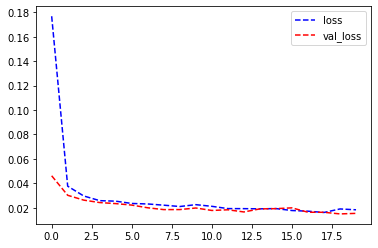

In [125]:
plt.plot(history_rnn.history['loss'], 'b--', label='loss')
plt.plot(history_rnn.history['val_loss'], 'r--', label='val_loss')
plt.legend()
plt.show()

In [126]:
# 테스트 데이터셋으로 검증 및 시각화
input_data = new_data[len(new_data) - len(test_data) - 10 : ].values
input_data = input_data.reshape(-1, 1)   # 차원 늘리기
input_data = scaler.transform(input_data)

In [128]:
print(input_data.shape[0])

47


In [130]:
# 검증 데이터셋
x_test = []
for i in range(10, input_data.shape[0]):
  x_test.append(input_data[i-10:i, 0])

In [131]:
# numpy 배열로 변환
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [132]:
# 예측
pred_temp1 = rnn_model.predict(x_test)
pred_temp1 = scaler.inverse_transform(pred_temp1)   # 정규화 역변환

2/2 [==============================] - 0s 9ms/step


In [134]:
train_data = new_data[:120]
valid_data = new_data[120:]
valid_data['pred'] = pred_temp1  # 예측결과 값을 새로운 열로 추가

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [135]:
valid_data

,temp1,pred
regdate,,
2019-04-10 10:20:00,37.8,34.042889
2019-04-10 10:21:00,37.5,34.338875
2019-04-10 10:22:00,37.5,34.118649
2019-04-10 10:23:00,37.5,34.141964
2019-04-10 10:24:00,37.0,34.193447
2019-04-10 10:25:00,30.1,33.696041
2019-04-10 10:26:00,13.4,26.641737
2019-04-10 10:27:00,16.0,11.971615
2019-04-10 10:28:00,18.3,17.790791


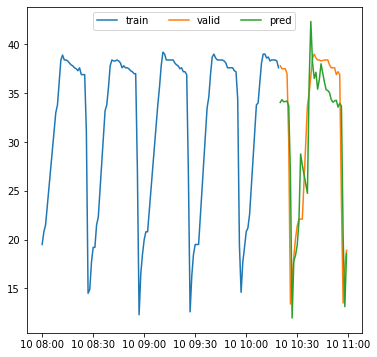

In [138]:
plt.figure(figsize=(6,6))
plt.plot(train_data['temp1'], label='train')
plt.plot(valid_data['temp1'], label='valid')
plt.plot(valid_data['pred'], label='pred')
plt.legend(loc = 9, ncol=3)
plt.show()